In [7]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
import sys
sys.path.insert(0,'..')

from image_processing.preprocessing import (
    remove_padding,
    pad_to_square
)

from image_processing.shape_normalization.moment import normalize as moment_normalization
from image_processing.shape_normalization.bimoment import normalize as bimoment_normalization
from image_processing.shape_normalization.p2d_bimoment import normalize as p2d_bimoment_normalization

In [4]:
# show a list of images
def show(imgs, col=5, titles=None, gray=True, chinese_title=False):
    
    chinese_font = mpl.font_manager.FontProperties(fname='../fonts/heiti.ttf')

    row = max((len(imgs) + col - 1) // col, 2)
    plt.figure(figsize=(col * 2.5, row * 2))
    
    for i in range(len(imgs)):
        ax = plt.subplot(row, col, i + 1)
        if gray:
            plt.imshow(imgs[i], 'gray')
        else:
            plt.imshow(imgs[i])
        if titles is not None:
            if chinese_title:
                plt.title(titles[i], fontproperties=chinese_font, fontsize=16)
            else:
                plt.title(titles[i])
        plt.axis("off")

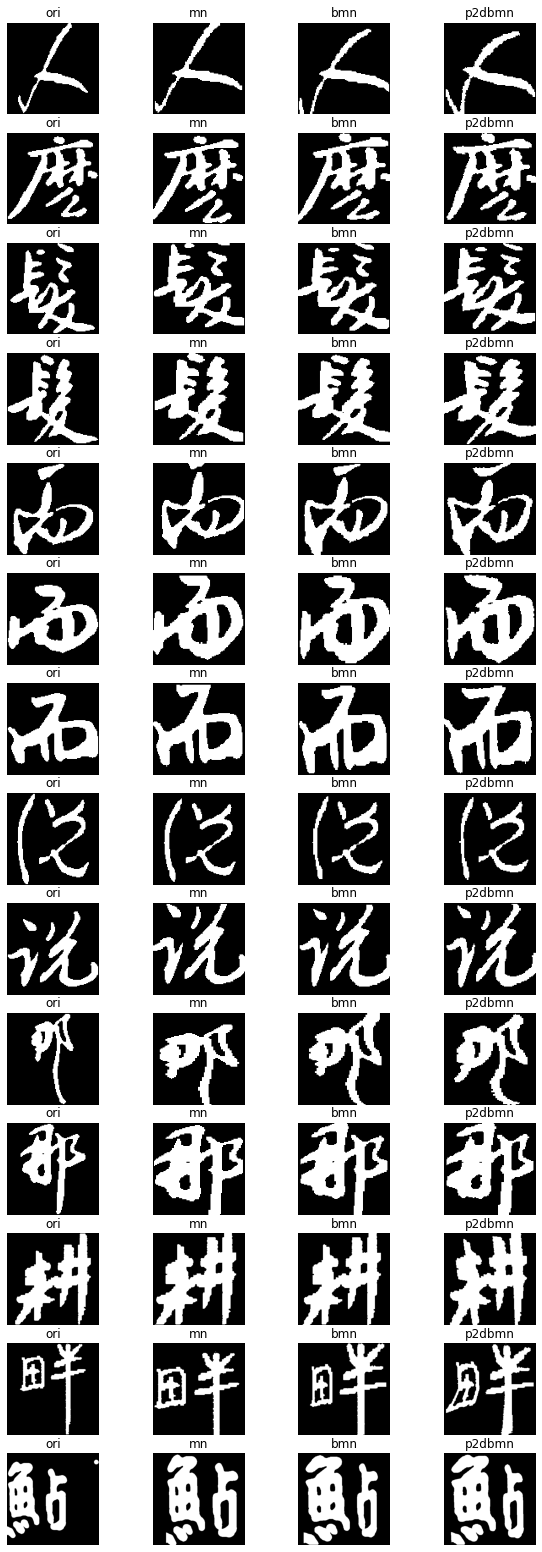

In [6]:
imgs = []
titles = []
fnames = [
    '../data/shufadict/clean/人/e56dbd8247f81ef7dc1a31e27d307b82.png',
    '../data/shufadict/clean/么/0f34c618b9643d08a1469892702d2007.png',
    '../data/shufadict/clean/发/2fc5822be330238690204267753d14c2.png',
    '../data/shufadict/clean/发/25c7c8b5d972ffd69870296df43a6884.png',
    '../data/shufadict/clean/而/5d2a6b1620b703e2f112c61d527585b9.png',
    '../data/shufadict/clean/而/9b00ab5a91f79fca33e8a8c1c0872643.png',
    '../data/shufadict/clean/而/f1e2bd97b285035a03de31e17fb0fd1a.png',
    '../data/shufadict/clean/说/2bed014d30fb1c554f84abeb24d64e6f.png',
    '../data/shufadict/clean/说/4aa84d1b2c3528603b4c7e63dd9e0b8b.png',
    '../data/shufadict/clean/那/8f5a4f9759115f2dc758d2253019c559.png',
    '../data/shufadict/clean/那/af052eb17df40cf2de16c4c748991964.png',
    '/Users/kx/desktop/test.png',
    '/Users/kx/desktop/test2.png',
    '/Users/kx/desktop/test3.png'
]
for fname in fnames:
    
    img_init = cv2.imread(fname)[:, :, 0]
    img_init = (img_init > 0) * 255
    img_init = remove_padding(img_init)
    
    img_mn = moment_normalization(img_init, alpha=4)
    img_bmn = bimoment_normalization(img_init, beta=2)
    img_p2dbmn = p2d_bimoment_normalization(img_init, beta=2, w0=0.5)
    
    imgs += [img_init, img_mn, img_bmn, img_p2dbmn]
    titles += ['ori', 'mn', 'bmn', 'p2dbmn']

imgs = [pad_to_square((img > 0).astype('uint8'), max(img.shape)) for img in imgs]
show(imgs, col=4, titles=titles)

---

# PDF estimation

In [ ]:
import scipy.stats as stats
import random
from tqdm.notebook import tqdm
# from multiprocessing import Pool
from multiprocess import Pool

In [ ]:
DATA_PATH = '../data/shufadict/clean'
N = 16

In [ ]:
chars = [x for x in os.listdir(DATA_PATH) if x[0] != '.']
char_to_id = dict(zip(chars, range(len(chars))))

In [ ]:
def preprocess_image_pdfe(img, N, norm_func):
    
    img = remove_padding(img)
    img_norm = norm_func(img, get_bmn_mapping, alpha=4)
    
    h, w = img_norm.shape
    if h > w:
        img_norm = cv2.resize(img_norm, (N, int(w / h * N)))
    else:
        img_norm = cv2.resize(img_norm, (int(h / w * N), N))
    img_norm = (img_norm > 0).astype('uint8')
    img_norm = pad_to_square(img_norm, N)
    
    return img_norm


def get_kernel_contour(kernel, N, step):
    # get meshgrid and its coordinates
    xx, yy = np.mgrid[0:N:step, 0:N:step]
    positions = np.vstack([xx.ravel(), yy.ravel()])

    # estimation
    f = np.reshape(kernel(positions).T, xx.shape)
    f = np.rot90(np.rot90(np.rot90(f)))
    
    return f

def plot_kernel_contour(kernel, N, step):
    
    f = get_kernel_contour(kernel, N, step)

    # plot
    fig = plt.figure(figsize=(3,3))
    ax = fig.gca()
    ax.set_xlim(0, N)
    ax.set_ylim(0, N)
    # ax.contourf(xx, yy, f, cmap='coolwarm')
    # ax.contour(xx, yy, f, colors='black')
    ax.imshow(np.rot90(f), cmap='coolwarm', extent=[0, N, 0, N])
    ax.axis("off")
    

## Preprocess data

In [ ]:
train = {}
val = {}
test = {}

for char in tqdm(chars):
    path = os.path.join(DATA_PATH, char)
    fnames = [os.path.join(path, f) for f in os.listdir(path) if f[0] != '.']
    imgs = []

    for fname in fnames:
        img = cv2.imread(fname)[:, :, 0]
        img_norm = preprocess_image_pdfe(img, N, moment_normalization_skel)
        imgs.append(img_norm)

    random.shuffle(imgs)
    test[char] = imgs[0:20]
    val[char] = imgs[20:40]
    train[char] = imgs[40:]

## PDF Estimation

In [ ]:
Xs = [None] * len(chars)
kernels = [None] * len(chars)
for i in tqdm(range(len(chars))):
    char = chars[i]
    imgs = train[char]
    Xs[i] = np.concatenate([np.argwhere(img) for img in imgs], axis=0)
    kernels[i] = stats.gaussian_kde(Xs[i].T)

In [ ]:
plot_kernel_contour(kernels[6], N=N, step=16j)

## Likelihood

In [ ]:
test_preds = {}

for char in tqdm(test):
#     char_id = 23
    char_id = char_to_id[char]
    char = chars[char_id]

    preds = [[None] * len(chars) for _ in range(len(test[char]))]

    for i in (range(len(test[char]))):
        for j in range(len(chars)):
            coords = np.argwhere(test[char][i]).T  
            f = kernels[j](coords)
            preds[i][j] = np.log(f).sum()
            
    test_preds[char] = preds

## Top-1 acc

In [ ]:
accs = [None] * len(chars)
for char_id in range(len(chars)):
    preds = test_preds[chars[char_id]]
    accs[char_id] = (np.argmax(preds, axis=1) == char_id).sum() / 20
    
accs = np.array(accs)
accs.mean()

In [ ]:
plt.hist(accs, [i/10 for i in range(10)])
plt.xlabel('top-1 acc')
plt.ylabel('freq')

## ...

In [ ]:
np.argwhere(accs < 0.5)[:, 0]

0 - 后 - pdf too similar to 这, variants
4 - 如 - too unconstrained
7 - 最 - variants, image too small?
10 - 国 - pdf too similar to 用同
13 - 看 - image too small???
19 - 就 - ???
21 - 发 - variants
31 - 从 - ???


? - variants 么

In [ ]:
char_id = 37
char = chars[char_id]

print(accs[char_id])

preds = test_preds[chars[char_id]]

preds = np.array(preds)
preds_sorted = np.argsort(-preds, axis=1)
preds_rank = np.argwhere(preds_sorted == char_id)[:, 1]

titles = []
for i in range(len(test[char])):
    titles.append(','.join([chars[preds_sorted[i, j]] for j in range(3)]))
    titles[-1] += str(preds[i, preds_sorted[i, 0]].round())
    
show(test[char], titles=titles, chinese_title=True)
# show(train[char])

In [ ]:
_ = plot_kernel_contour(kernels[char_id], N=N, step=16j)

In [ ]:
_ = plot_kernel_contour(kernels[char_to_id['后']], N=N, step=16j)

In [ ]:
_ = plot_kernel_contour(kernels[char_to_id['这']], N=N, step=16j)

In [ ]:
fs = [get_kernel_contour(kernels[char_id], N=N, step=16j) for char_id in range(len(chars))]

In [ ]:
for i in range(len(fs)):
    fs[i] = (fs[i] - fs[i].min()) / (fs[i].max() - fs[i].min())

In [ ]:
l2 = [[None] * len(fs) for _ in range(len(fs))]

for i in range(len(fs)):
    for j in range(i + 1, len(fs)):
        l2[i][j] = ((fs[i] - fs[j]) ** 2).sum() ** 0.5

In [ ]:
i = 0
min(l2[i][i + 1:])

In [ ]:
tmp = []
for i in range(len(l2) - 1):
    j = np.argmin(l2[i][i + 1:]) + 1 + i
    tmp.append((chars[i], chars[j], l2[i][j]))
#     print(chars[i], chars[j], l2[i][j])

In [ ]:
sorted(tmp, key=lambda x: x[2])[50]

In [ ]:
_ = plot_kernel_contour(kernels[3], N=N, step=16j)

In [ ]:
f = fs[char_to_id['也']]

fig = plt.figure(figsize=(3,3))
ax = fig.gca()
ax.set_xlim(0, N)
ax.set_ylim(0, N)
# ax.contourf(xx, yy, f, cmap='coolwarm')
# ax.contour(xx, yy, f, colors='black')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[0, N, 0, N])
ax.axis("off")

In [ ]:
# multiprocessing kde

# n_cores = 2
# char = '起'

# with Pool(n_cores) as pool:

#     preds = [[None] * len(chars) for _ in range(len(test[char]))]

#     for i in tqdm(range(len(test[char]))):
#         for j in range(len(chars)):
#             coords = np.argwhere(test[char][i]).T            
#             tasks = [(x, kernels[j]) for x in np.array_split(coords, n_cores, axis=1)]
#             results = pool.map(lambda x: x[1](x[0]), tasks)
#             preds[i][j] = sum([np.log(x).sum() for x in results])
        